<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1f_regresion_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión logística

<div style="text-align: right"> Bere et Richardt </div>

---

En este ejemplo veremos como implementar regresión logisitica para un atributo. Este modelo se puede ver como la forma más simple de una red neuronal para clasificación, por lo que es importante comprenderlo a profundidad.


## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# sistema de archivos
import os
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url


# directorio de datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/iris/iris.csv'
base_dir = '../data/iris/'
filename = 'iris.csv'
filepath = os.path.join(base_dir, 'iris.csv')


# para reproducibilidad
SEED = 1
torch.manual_seed(SEED)

## 2 Datos

Emplearemos un conjunto referencia llamado Iris recolectado por Ronald Fisher (sí, el mismo del algoritmo de barajeo de Fisher-Yates). Este conjunto tiene cuatro atributos de entrada: los anchos y largos de los pétalos y sépalos; y tres clases de flor iris de salida: setosa, versicolour, virginica.

![Pétalo y sépalo](../figs/iris.png)
<center>Fuente: Suruchi Fialoke, October 13, 2016, Classification of Iris Varieties</center>

Este conjunto tiene 50 muestras de cada clase, leamoslo e imprimamos las primeras cinco de cada clase.



Descargamos los datos para el caso de Colab.

In [2]:
download_url(URL, base_dir, filename)

Using downloaded and verified file: ../data/iris/iris.csv


In [3]:
columns = ('largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo', 'clase')
df = pd.read_csv('../data/iris/iris.csv', names=columns)
pd.concat((df[1:5], df[50:55], df[100:105]))  

,largo sépalo,ancho sépalo,largo pétalo,ancho pétalo,clase
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica


El modelo de regresión logística que entrenaremos resolvera una tarea de clasificación binaria sobre este conjunto considerando únicamente como entrada el largo del pétalo y como salida las dos primeras clases. Grafiquemos la entrada contra la salida para visualizar su relación.

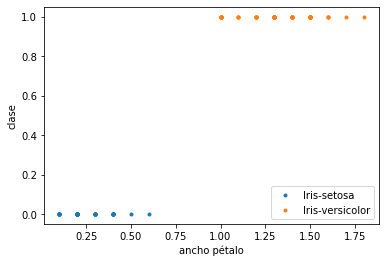

In [4]:
label2index = {'Iris-setosa': 0, 'Iris-versicolor': 1}
x_trn = np.array(df.iloc[:, 3][:100], dtype="float32")[..., np.newaxis]
y_trn = [label2index[l] for l in df.iloc[:, -1][:100]]
y_trn = np.array(y_trn, dtype="float32")[..., np.newaxis]
plt.plot(x_trn[:50], y_trn[:50], '.', label='Iris-setosa')
plt.plot(x_trn[50:], y_trn[50:], '.', label='Iris-versicolor')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right')
plt.show()

### 2.1 Tuberias de datos con PyTorch


![data](../figs/regresion_logistica_datos.png)

In [5]:
class IrisDS:
    
    def __init__(self, X, Y):
        self.x = X
        self.y = Y

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.y)

### 2.2 Exploración


Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [6]:
# tamaño del lote
batch_size = 32

# creamos un Dataset
ds = IrisDS(x_trn, y_trn)

# creamos un DataLoader
trn_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 1]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


In [7]:
len(ds)

100

## 3 Modelo

### 3.1 Definición de la arquitectura

#### Alto nivel (similar a Keras) 

In [8]:
model = nn.Sequential(
    nn.Linear(1, 1),
    nn.Sigmoid()
)

#### Medio nivel (Chainer, tensorflow.keras.model) 

In [9]:
#se define la clase RegLog que hereda de torch.nn.Module
class RegLog(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super(RegLog, self).__init__()
        # importante: se definen las capas como atributos de la clase
        self.fc = nn.Linear(1, 1)

    # método para inferencia
    def forward(self, x):
        # definición de arquitectura 
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

# model = RegLog()

### 3.3 Impresión de la arquitectura

In [10]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)


### 3.4 Prueba de la arquitectura

In [11]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1)
y = model(x)
print(x.dtype)
print(y.shape)
print(y.dtype)

torch.float32
torch.Size([1, 1])
torch.float32


### Quiz 1

¿Qué modelo sencillo podríamos usar para realizar clasificación de las tres clases?

## 4 Entrenamiento

### 4.1 Ciclo de entrenamiento

Realizamos el entrenamiento de nuestro modelo durante dos epocas.

In [12]:
# optimizador
opt = optim.SGD(model.parameters(), lr=0.5)


# historial de pérdida
losses, accs = [], []

# ciclo de entrenamiento
EPOCHS = 6
for epoch in range(EPOCHS):

    
    # historial de pérdida
    losses_epoch, accs_epoch = [], []
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia
        y_prob = model(x)
        # calculamos de pérdida
        loss = F.binary_cross_entropy(y_prob, y_true)
        # obtenemos la clase predicha
        y_pred = torch.round(y_prob)
        # calculamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        losses_epoch.append(loss.item() * 100)
        accs_epoch.append(acc.item() * 100)

    # imprimimos métricas
    loss = np.mean(losses_epoch)
    acc = np.mean(accs_epoch)
    print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
    losses.append(loss)
    accs.append(acc)

E 0 loss= 73.31 acc=50.00
E 1 loss= 62.05 acc=55.47
E 2 loss= 60.55 acc=44.53
E 3 loss= 50.94 acc=71.88
E 4 loss= 49.50 acc=84.38
E 5 loss= 41.95 acc=99.22


Graficamos la exactitud para ver el comportamiento durante el entrenamiento.

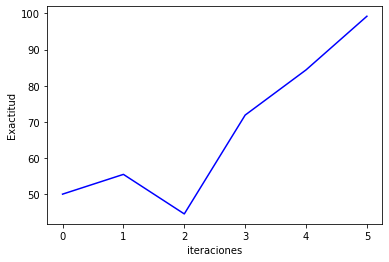

In [13]:
plt.plot(accs, color='blue')
plt.xlabel('iteraciones')
plt.ylabel('Exactitud');

Graficamos la pérdida para ver el comportamiento durante el entrenamiento.

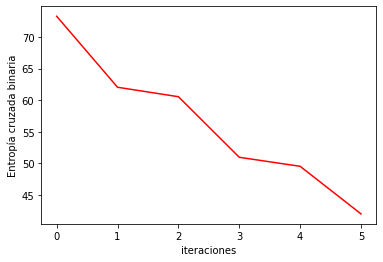

In [14]:
plt.plot(losses, color='red')
plt.xlabel('iteraciones')
plt.ylabel('Entropía cruzada binaria');

Obtenemos los parámetros de nuestro modelo.

In [15]:
[w, b] = model.parameters()

Imprimimos la pendiente:

In [16]:
w

Parameter containing:
tensor([[1.4888]], requires_grad=True)

Imprimimos la ordenada:

In [17]:
b

Parameter containing:
tensor([-0.6404], requires_grad=True)

### Quiz 2

¿Qué función de pérdida podríamos usar para realizar clasificación de las tres clases?

## Inferencia

Graficamos nuestro modelo.

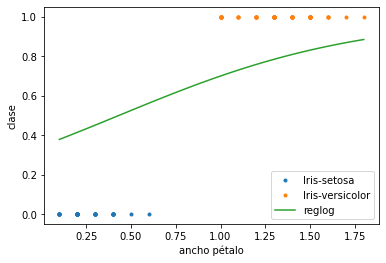

In [18]:
x_train = torch.from_numpy(x_trn)

with torch.no_grad():
    y_pred = model(x_train).numpy()

w, b = w.item(), b.item()
sigmoid = lambda x: (1 / (1 + np.exp(-x)))
x_model = np.linspace(x_train[:100].min(), x_train[:100].max(), 100)[..., np.newaxis]
y_model = sigmoid(x_model * w + b)
plt.plot(x_trn[:50], y_trn[:50], '.', label='Iris-setosa')
plt.plot(x_trn[50:], y_trn[50:], '.', label='Iris-versicolor')
plt.plot(x_model, y_model, label='reglog')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right')
plt.show()

### Quiz 3

¿Qué pasaría con la pérdida y la gráfica de la función sigmoide si entrenamos durante 100 épocas?